In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [3]:
df = pd.read_csv('./datasets/final_train_dataset.csv')

In [4]:
df.index = pd.to_datetime(df.Datetime)
new_df = df[['Average_Receive_bps', 'Average_Transmit_bps']]
new_df.head()

,Average_Receive_bps,Average_Transmit_bps
Datetime,,
2023-08-01 00:00:00,338950304.0,65747312.0
2023-08-01 00:05:00,338950304.0,65747312.0
2023-08-01 00:10:00,338873216.0,61819992.0
2023-08-01 00:15:00,338873216.0,61819992.0
2023-08-01 00:20:00,338956608.0,69735288.0


In [5]:
# check number of nan values in dataframe
new_df.isna().sum()

Average_Receive_bps     0
Average_Transmit_bps    0
dtype: int64

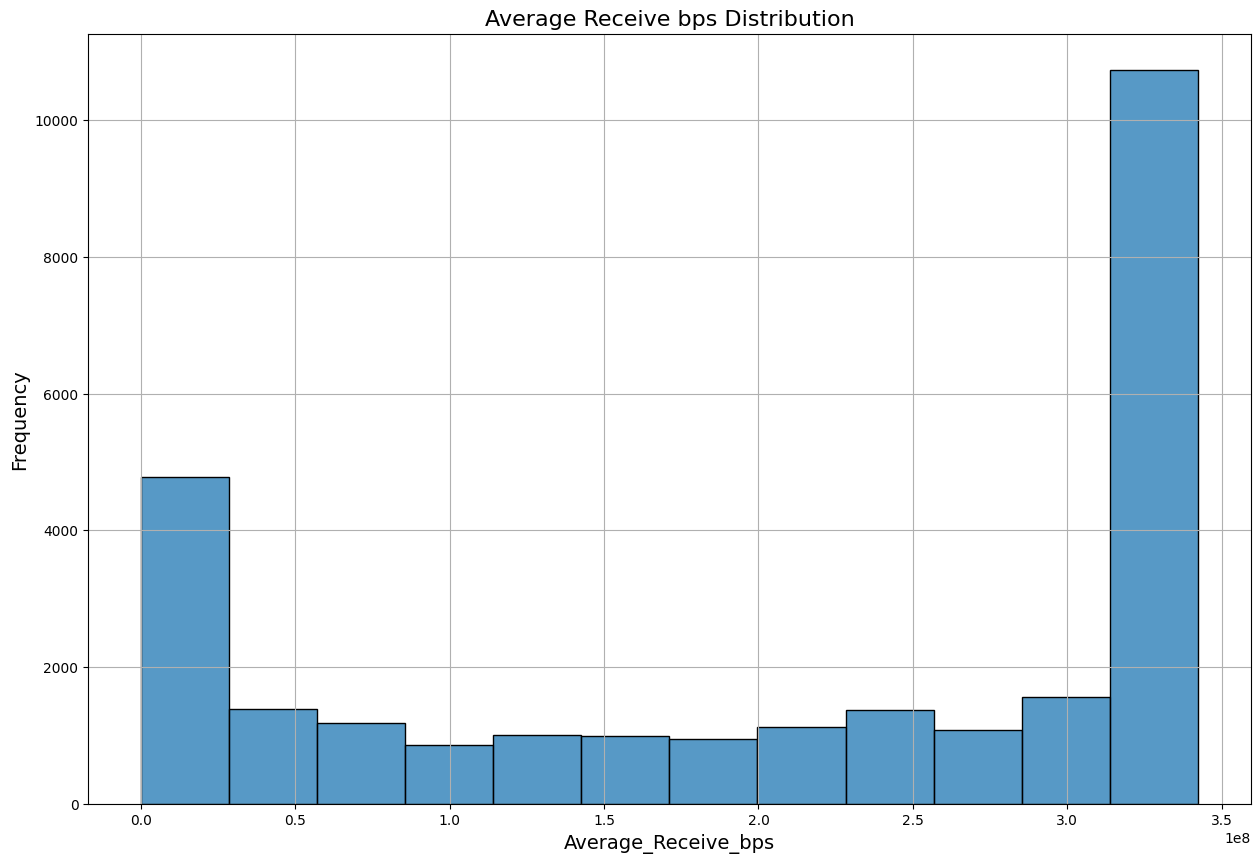

In [6]:
plt.figure(figsize=(15, 10))
# Plot a histogram of Average_Receive_bps with specified bin sizes
sns.histplot(new_df ['Average_Receive_bps'], bins=12, kde=False)
# Add a title and grid
plt.title("Average Receive bps Distribution", fontsize=16)
plt.xlabel("Average_Receive_bps", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True)
# Show the plot
plt.show()
     

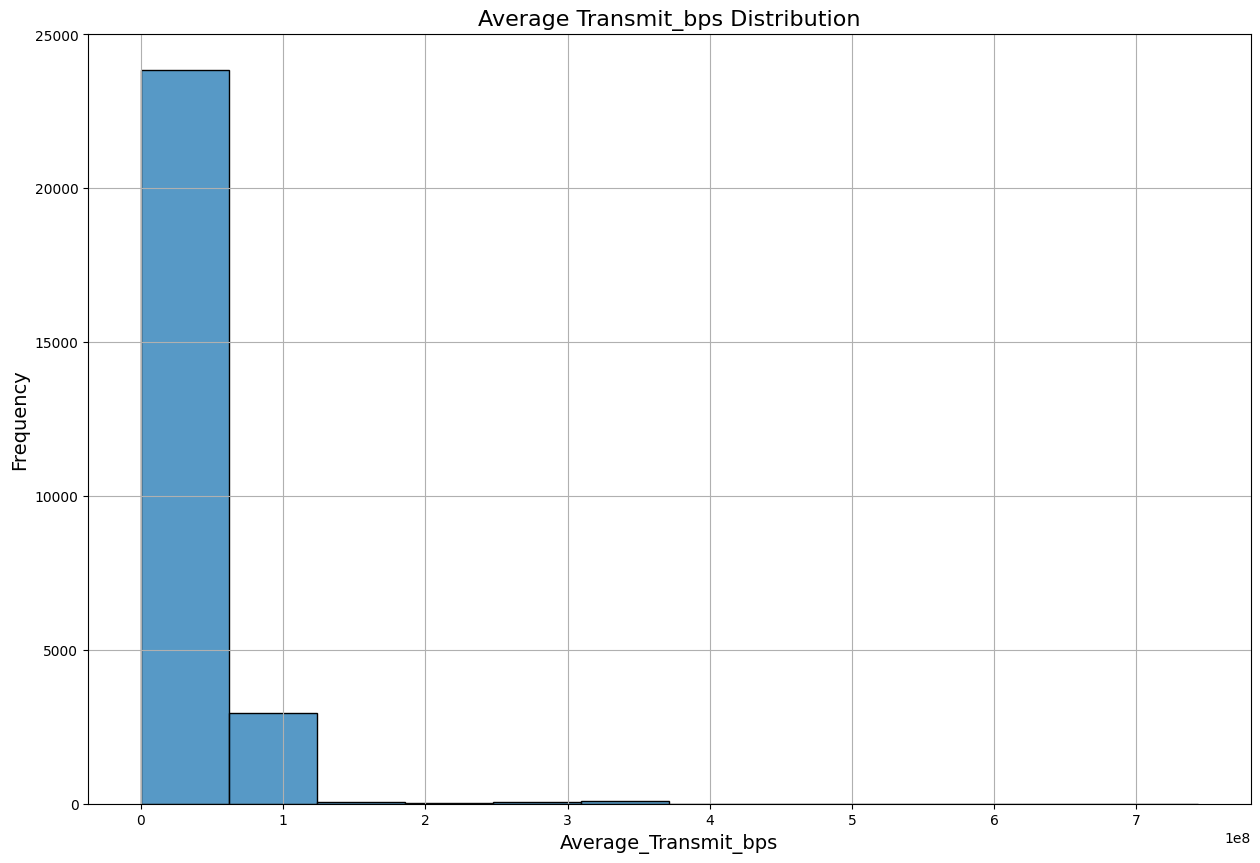

In [8]:
plt.figure(figsize=(15, 10))
# Plot a histogram of Average_Receive_bps with specified bin sizes
sns.histplot(new_df ['Average_Transmit_bps'], bins=12, kde=False)
# Add a title and grid
plt.title("Average Transmit_bps Distribution", fontsize=16)
plt.xlabel("Average_Transmit_bps", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True)
# Show the plot
plt.show()

In [ ]:
# Data Preprocessing

In [40]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(new_df)

# Define sequence length and features
sequence_length = 10  # Number of time steps in each sequence
num_features = len(new_df.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length]
    label = scaled_data[i+sequence_length][1]  # 'average_recieve_bmp' column index Target
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

In [41]:
print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (21600, 10, 2)
Train Y shape: (21600,)
Test X shape: (5401, 10, 2)
Test Y shape: (5401,)


In [ ]:
Creating layers for our model algorithim

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\Saint_Hacker\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 128)             │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,929 (503.63 KB)

 Trainable params: 128,929 (503.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training Our Model

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('./models/best_model_weights.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 6.6802e-04 - val_loss: 0.0020
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 3.7759e-04 - val_loss: 0.0017
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 3.0523e-04 - val_loss: 0.0014
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 2.4157e-04 - val_loss: 0.0011
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 2.1521e-04 - val_loss: 0.0010
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.8878e-04 - val_loss: 9.9234e-04
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 1.6993e-04 - val_loss: 8.7055e-04
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 1.8999e-04 - val_loss: 7.7914e-04
Epoch 9/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 1.7121e-04 - val_loss: 7.6315e-04
Epoch 10/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 1.4855e-04 - val_loss: 7.8177e-04
Epoch 11/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - 

In [46]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('./models/best_model_weights.keras')
test_loss = best_model.evaluate(test_x, test_y)
print("Test Loss:", test_loss)

169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.2167e-04
Test Loss: 0.0005931475316174328


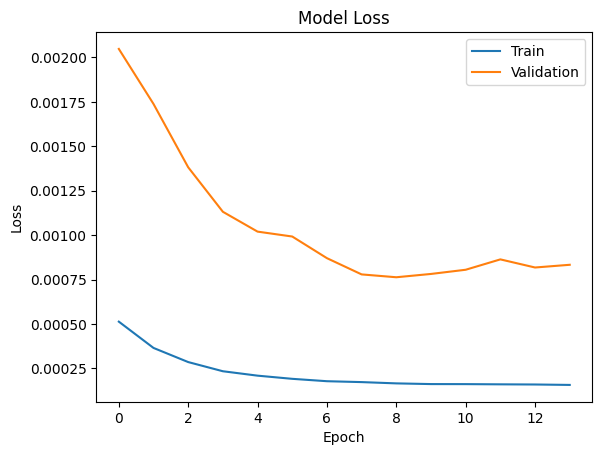

In [47]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Assuming you have trained the model and have the 'best_model' object
# Also, 'test_x' and 'test_y' should be available

# Predict average_recieve_bps using the trained model
predictions = best_model.predict(test_x)

# Calculate evaluation metrics
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Mean Absolute Error (MAE): 0.009381132172825426
Mean Squared Error (MSE): 0.0005931474074749531
Root Mean Squared Error (RMSE): 0.0243546177854417


In [63]:
# y_true values
test_y_copies = np.repeat(test_y.reshape(-1, 1), test_x.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copies)[:,1]

# predicted values
prediction = best_model.predict(test_x)
prediction_copies = np.repeat(prediction, 2, axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,1]

169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


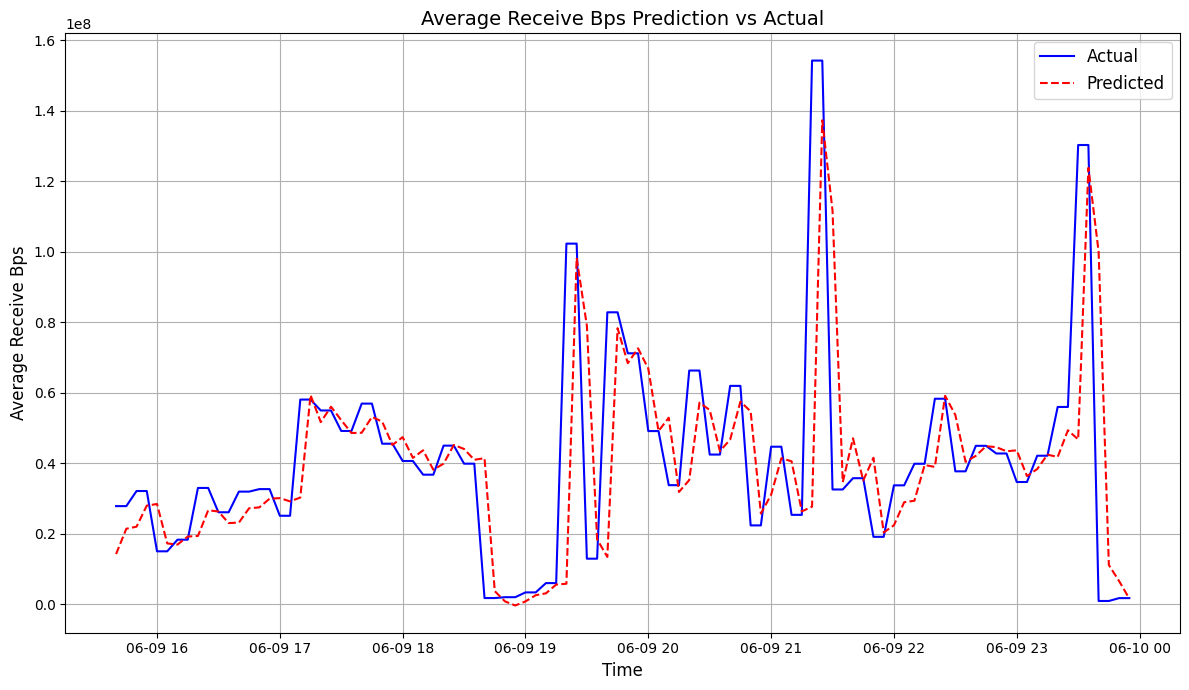

In [66]:
import matplotlib.pyplot as plt

# Ploting predicted and actual values
plt.figure(figsize=(12, 7))  # Increase the size for better readability
plt.plot(new_df.index[-100:], true_temp[-100:], color='blue', linestyle='-', marker='', label='Actual')
plt.plot(new_df.index[-100:], predicted_temp[-100:], color='red', linestyle='--', marker='', label='Predicted')

plt.title('Average Receive Bps Prediction vs Actual', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Average Receive Bps', fontsize=12)
plt.legend(loc='best', fontsize=12)

plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to fit labels and titles
plt.show()


In [159]:
import pickle
# Step 2: Save the MinMaxScaler using pickle
scaler_save_path = './models/minmax_scaler.pkl'
with open(scaler_save_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Scaler saved to {scaler_save_path}")


Scaler saved to ./models/minmax_scaler.pkl
